In [43]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
from itertools import product
import re
from copy import deepcopy
import random

In [44]:
def neighbor_edges_of_node(graph, node):
    neighbor_edges = []
    for edge in graph.edges():
        if node in edge:
            neighbor_edges.append(edge)
    return neighbor_edges

In [45]:
def is_valid_coloring(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    
    for edge in graph.edges():
        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                return False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                return False
    return True

In [46]:
def initialize(graph):
    return [random.randrange(1, len(graph.edges())) for _ in range(len(graph.edges()))]

In [47]:
# number of edges that are correctly colored 
def calculate_value(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    num = 0

    for edge in graph.edges():
        indicator = True

        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                indicator = False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                indicator = False

        if indicator:
            num += 1
    
    return len(graph.edges()) - num

In [48]:
def make_small_change_colors(solution):
    max_num = max(solution)
    second_max = max(num for num in solution if num != max_num)

    new_solution = [second_max if num == max_num else num for num in solution]
    return new_solution

In [49]:
def make_small_change_shuffle(graph, solution):
    new_solution = deepcopy(solution)
    random_idx = random.randrange(len(solution))
    new_solution[random_idx] = random.randrange(1, len(graph.edges()))

    return new_solution

In [50]:
def simulated_annealing(graph, max_iter=1000000, initial_temperature=10000.0, cooling_rate=0.95):
    coloring_result = initialize(graph)
    value = calculate_value(graph, coloring_result)

    best_coloring = None
    best_value = float('inf')
    
    current_temperature = initial_temperature
    iter_found = 0

    for i in range(max_iter):
        
        # if current_temperature < 0.1:
        #     break
        
        if is_valid_coloring(graph, coloring_result):
            # reduce the number of colors by one
            new_coloring = make_small_change_colors(coloring_result)
            new_value = calculate_value(graph, new_coloring)
        else:
            # change one random position to a different color
            new_coloring = make_small_change_shuffle(graph, coloring_result)
            new_value = calculate_value(graph, new_coloring)
            
        if new_value < value:
            coloring_result = deepcopy(new_coloring)
            value = new_value 
            if new_value < best_value:          
                if is_valid_coloring(graph, new_coloring):          
                    best_coloring = deepcopy(new_coloring)
                    best_value = new_value
                    iter_found = i
        else:
            delta = new_value - value
            if delta < 0 or random.random() < current_temperature:
                coloring_result = deepcopy(new_coloring)
                value = new_value

        current_temperature *= cooling_rate

    return best_coloring, iter_found

In [51]:
def draw_colored_graph(graph, coloring):    
    nx.draw(graph, with_labels=True, edge_color=coloring)
    plt.show()

In [52]:
def read_graph_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_nodes, num_edges = map(int, lines[0].split()[2:])  # extractiong num_nodes and num_edges
        edges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        graph = nx.Graph()
        graph.add_nodes_from(range(1, num_nodes + 1))
        graph.add_edges_from(edges)
        
        return graph

In [53]:
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    parts[1] = int(parts[1]) if len(parts) > 1 else 0
    return parts

In [54]:
def write_output(graph, test_name, coloring_result, iter, start_time, end_time):
    with open('./results/simulatedAnnealing_results.txt', 'a') as result_file:
        result_file.write(f"Test Name: {test_name}\n")
        result_file.write("Result: ")
        
        if coloring_result == -1:
            result_file.write("Time limit exceeded.\n")
            print("Time limit exceeded.\n")
        else:
            if coloring_result:
                result_file.write("Minimum edge coloring found.\n")
                result_file.write(f"Number of colors: {len(set(coloring_result))}\n")
                result_file.write(f"Number of iterations: {iter}\n")

                print("Minimum edge coloring found.")
                print("Number of colors:", len(set(coloring_result)))  
                print("Number of iterations:", iter)
                draw_colored_graph(graph, coloring_result)
                plt.close() 
            else:
                result_file.write("No solution found.\n")
                print("No solution found.\n") 

        time_taken = end_time - start_time

        result_file.write(f"Time taken (seconds): {time_taken}\n")    
        result_file.write("\n")
        print("Time taken:", end_time - start_time, "seconds\n")


In [55]:
def run_tests(directory):
    files = os.listdir(directory)
    sorted_files = sorted(files, key=numerical_sort)

    for file in sorted_files:
        if file.endswith('.txt'):
            filepath = os.path.join(directory, file)
            print(f"Running test {file}...")
            
            start_time = time.time()
            graph = read_graph_from_file(filepath)
            coloring_result, iter = simulated_annealing(graph, max_iter=1000, initial_temperature=100.0, cooling_rate=0.95)
            end_time = time.time()
            
            write_output(graph, file, coloring_result, iter, start_time, end_time)         

Running test graph_101_edges.txt...
Minimum edge coloring found.
Number of colors: 67
Number of iterations: 313


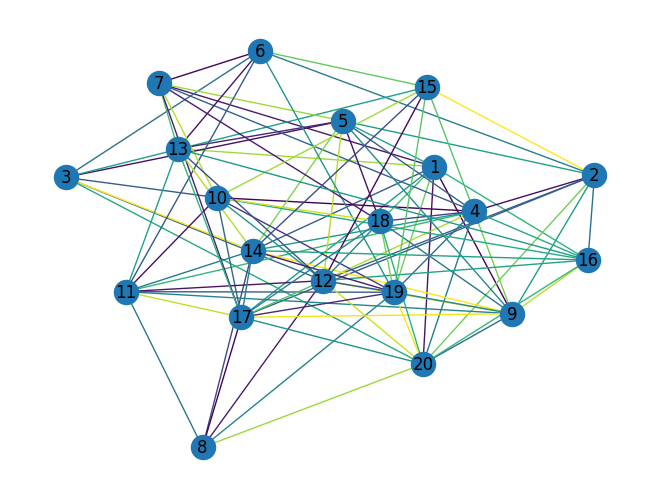

Time taken: 13.255566835403442 seconds

Running test graph_121_edges.txt...
Minimum edge coloring found.
Number of colors: 82
Number of iterations: 309


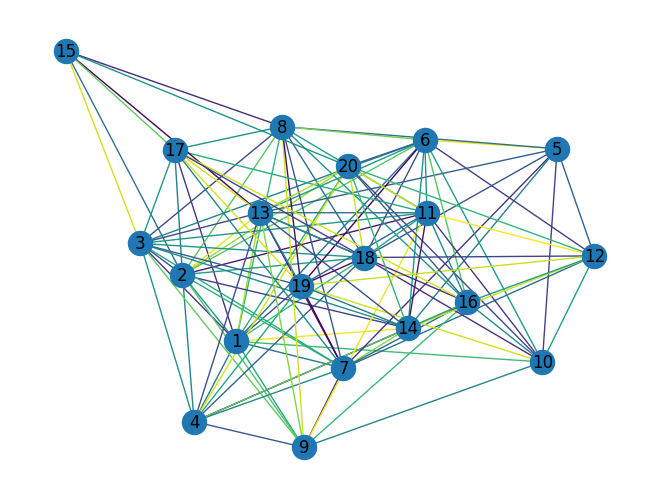

Time taken: 17.513259887695312 seconds

Running test graph_140_edges.txt...
Minimum edge coloring found.
Number of colors: 97
Number of iterations: 384


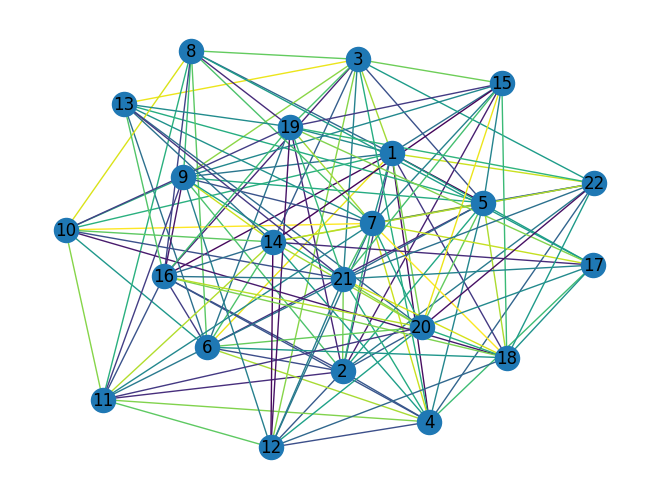

Time taken: 24.772459983825684 seconds

Running test graph_156_edges.txt...
Minimum edge coloring found.
Number of colors: 100
Number of iterations: 400


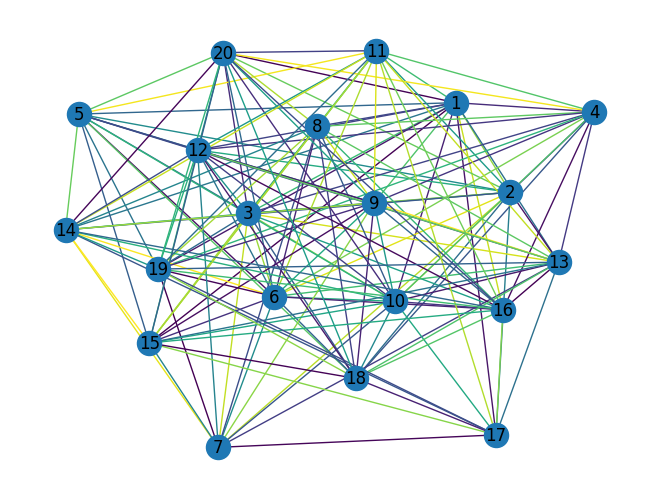

Time taken: 28.694588661193848 seconds

Running test graph_165_edges.txt...
Minimum edge coloring found.
Number of colors: 112
Number of iterations: 358


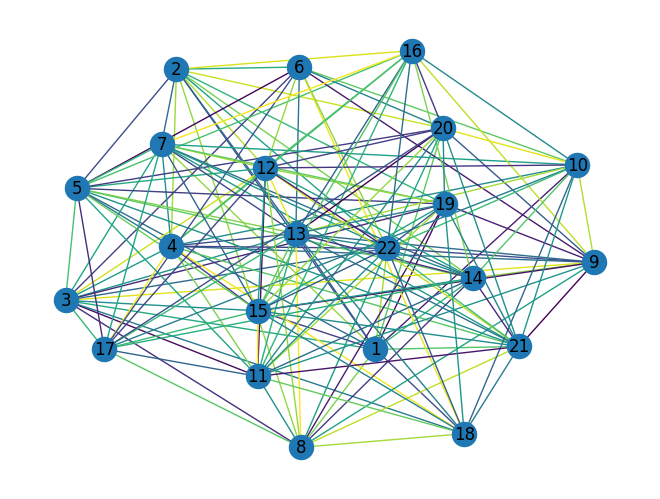

Time taken: 31.178021669387817 seconds

Running test graph_177_edges.txt...
Minimum edge coloring found.
Number of colors: 120
Number of iterations: 668


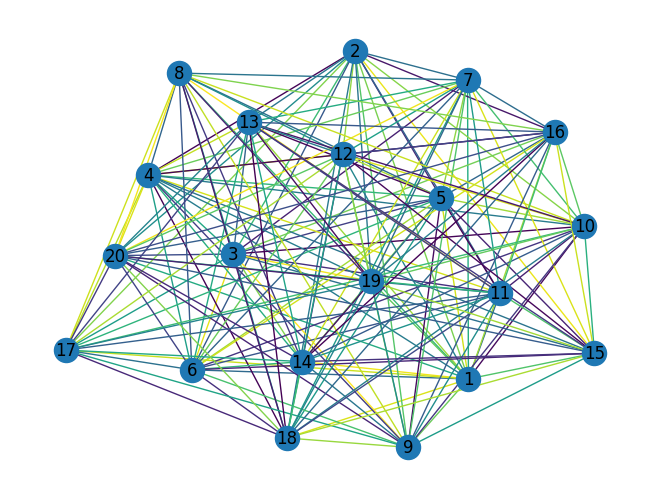

Time taken: 30.310826301574707 seconds

Running test graph_204_edges.txt...
Minimum edge coloring found.
Number of colors: 138
Number of iterations: 553


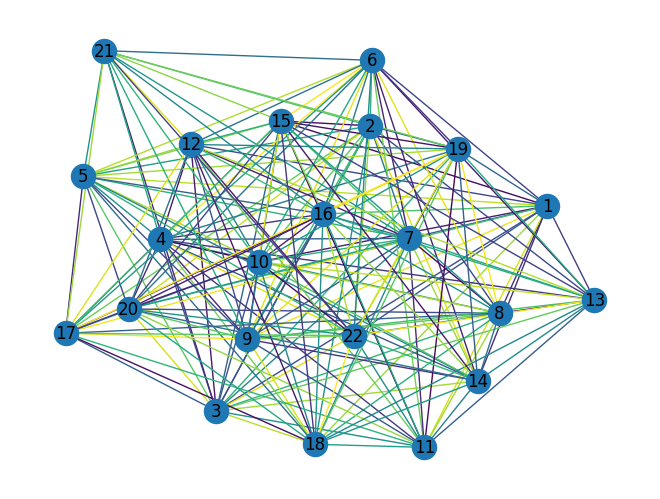

Time taken: 38.80235266685486 seconds

Running test graph_227_edges.txt...
Minimum edge coloring found.
Number of colors: 148
Number of iterations: 407


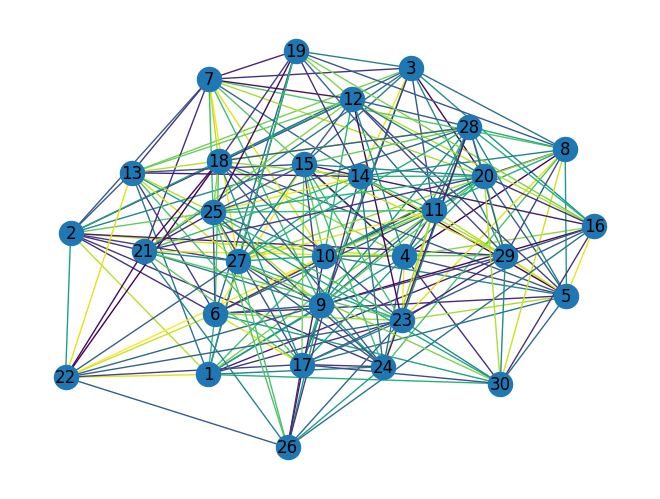

Time taken: 51.85737752914429 seconds

Running test graph_273_edges.txt...
Minimum edge coloring found.
Number of colors: 175
Number of iterations: 712


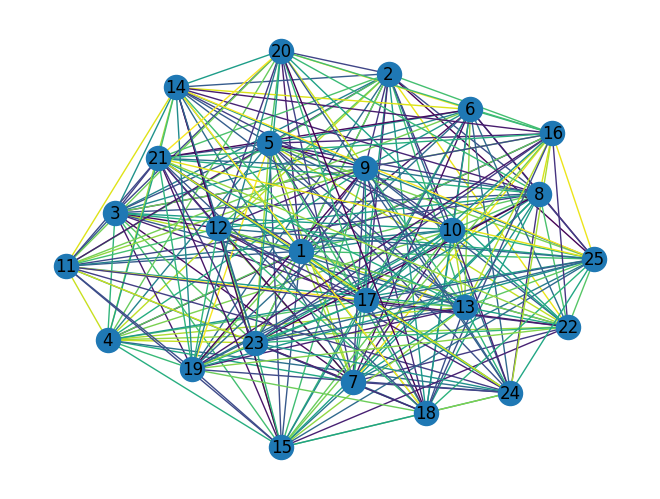

Time taken: 60.587078332901 seconds

Running test graph_275_edges.txt...
Minimum edge coloring found.
Number of colors: 179
Number of iterations: 600


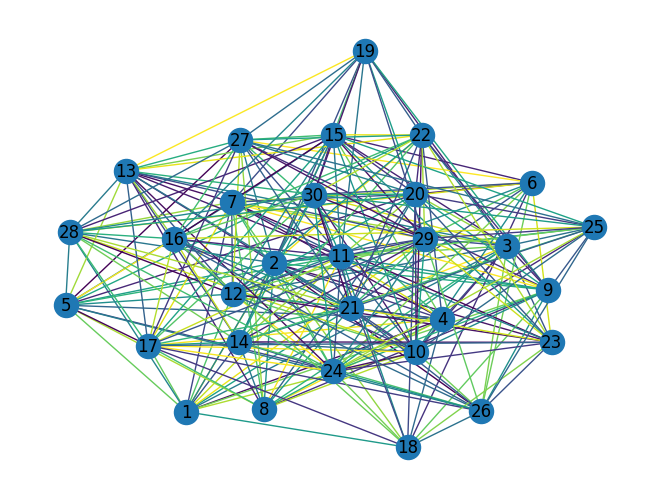

Time taken: 69.12135934829712 seconds



In [57]:
with open('./results/simulatedAnnealing_results.txt', 'w') as result_file:
    result_file.write("")

run_tests('./tests')